In [1]:
import json
import random
import sys

sys.path.insert(1, '../../src')

from ce.algorithms.greedy_heuristics import random_solution
from ce.algorithms.local_search import steepest_local_search, two_edges_neighborhood, two_nodes_neighborhood, steepest_local_candidates_search, two_edges_candidates_neighborhood, two_nodes_candidates_neighborhood
from ce.tsp_optimized import create_tsp, TSP
from ce.utils.experiments import run_all_experiments

random.seed(13)

# Local Search

**Nina Zukowska 148278, Antoni Solarski 148270**

In [2]:
problem_instance_A_path = '../../data/TSPA.csv'
problem_instance_B_path = '../../data/TSPB.csv'
problem_instance_C_path = '../../data/TSPC.csv'
problem_instance_D_path = '../../data/TSPD.csv'

In [3]:
tspa, tspb, tspc, tspd = create_tsp(problem_instance_A_path), create_tsp(problem_instance_B_path), create_tsp(problem_instance_C_path), create_tsp(problem_instance_D_path)

## Algorithms

### Initial solution generation: random generation

---

### Next solution generation (typical steepest)

For each of the methods we implemented three different functions to:
- generate all possible 'moves' that creates new solution
- calculate a cost difference for a given move
- construct new solution for a given move

#### Inter route

```python
def inter_route_moves(solution: List[int], tsp: TSP):
    # replace any node of the solution with any node from the rest
    # return pair (position_to_replace, node_idx_to_insert)
    outer_nodes = [i for i in tsp.indexes if i not in solution]
    for i, _ in enumerate(solution):
        for n in outer_nodes:
            yield i, n


def inter_route_cost_delta(solution: List[int], move: Tuple[int, int], tsp: TSP) -> int:
    i, outer_node = move
    node_to_replace = solution[i]
    before, after = solution[(i - 1) % len(solution)], solution[(i + 1) % len(solution)]

    return (
            + tsp.nodes[outer_node].cost - tsp.nodes[node_to_replace].cost
            + tsp.distances[before, outer_node] + tsp.distances[outer_node, after]
            - tsp.distances[before, node_to_replace] - tsp.distances[after, node_to_replace]
    )


def inter_route_new_solution(solution: List[int], move: Tuple[int, int]) -> List[int]:
    i, outer_node = move
    return solution[:i] + [outer_node] + solution[i + 1:]ut``n[replacement + 1:]
```

#### 2-nodes exchange

```python
def two_nodes_moves(solution: List[int]):
    # exchange position of any two nodes
    # return pair (position_1, position_2)
    for i, _ in enumerate(solution):
        for j, _ in enumerate(solution):
            # first node is fixed to not generate different (but same) neighbors
            if 0 < i < j:
                yield i, j


def two_nodes_cost_delta(solution: List[int], move: Tuple[int, int], tsp: TSP) -> int:
    i, j = move
    node1, node2 = solution[i], solution[j]
    before1, after1 = solution[(i - 1) % len(solution)], solution[(i + 1) % len(solution)]
    before2, after2 = solution[(j - 1) % len(solution)], solution[(j + 1) % len(solution)]

    return (
            + tsp.distances[before1, node2] + tsp.distances[node2, after1]
            + tsp.distances[before2, node1] + tsp.distances[node1, after2]
            - tsp.distances[before1, node1] - tsp.distances[node1, after1]
            - tsp.distances[before2, node2] - tsp.distances[node2, after2]
    )


def two_nodes_new_solution(solution: List[int], move: Tuple[int, int]) -> List[int]:
    i, j = move
    return solution[:i] + [solution[j]] + solution[i + 1:j] + [solution[i]] + solution[j + 1:]
```i]] + solution[j + 1:]
```

### 2-edges exchange

```python
def two_edges_moves(solution: List[int]):
    # exchange position of any two edges
    # return pair (position_of_edge_1, position_of_edge_2)
    # edge nr i connects nodes i and i+1
    for i, _ in enumerate(solution):
        for j, _ in enumerate(solution):
            # no point in exchanging adjacent edges
            if i < j and (j - i) > 1 and not (i == 0 and j == len(solution) - 1):
                yield i, j


def two_edges_cost_delta(solution: List[int], move: Tuple[int, int], tsp: TSP) -> int:
    i, j = move
    from1, to1 = solution[i], solution[(i + 1) % len(solution)]
    from2, to2 = solution[j], solution[(j + 1) % len(solution)]
    return (
            - tsp.distances[from1, to1] - tsp.distances[from2, to2]
            + tsp.distances[from1, from2] + tsp.distances[to1, to2]
    )


def two_edges_new_solution(solution: List[int], move: Tuple[int, int]) -> List[int]:
    i, j = move
    return solution[:i + 1] + solution[j:i:-1] + solution[j + 1:]
```

---

### Steepest local search

```python
def steepest_local_search(tsp: TSP, init_solution, neighborhood) -> List[int]:
    solution = init_solution
    local_optimum = False

    while not local_optimum:
        best_neighbor = min(neighborhood(solution, tsp), key=lambda x: get_cost_delta(x, solution, tsp))
        if get_cost_delta(best_neighbor, solution, tsp) < 0:
            solution = get_new_solution(best_neighbor, solution)
        else:
            local_optimum = True

    return solution
```

---
### Introducing the candidate edges ( calculated as follows:)
```python
def get_candidate_edges_for_solution_vertex(tsp: TSP, vertex: int, n: int = 10):
    # outer nodes are nodes not in solution
    outer_nodes = [i for i in tsp.indexes if i != vertex]

    costs = []
    for outer_node in outer_nodes:
        # calculate cost of inserting outer node between previous and next vertex
        cost = tsp.distances[vertex, outer_node] + tsp.nodes[outer_node].cost
        costs.append((outer_node, cost))

        # get n best candidates
    costs.sort(key=lambda x: x[1])
    candidate_edges = set([(vertex, costs[i][0]) for i in range(n)])
    return candidate_edges

def calculate_candidate_endges(tsp: TSP):
    set_of_candidate_edges = set()
    for i, _ in enumerate(tsp.indexes):
        candidate_edges = tsp.get_candidate_edges_for_solution_vertex(i)
        # add candidate edges to set
        set_of_candidate_edges.update(candidate_edges)
    return set_of_candidate_edges
```

makes the neighborhood function change as follows:

```python

def two_nodes_candidates_neighborhood(solution: List[int], tsp: TSP, candidate_edges: set):
    neighborhood = (
            [('i', move) for move in inter_route_candidate_moves(solution, tsp, candidate_edges)]
            + [('2n', move) for move in two_nodes_candidate_moves(solution, candidate_edges)]
    )
    random.shuffle(neighborhood)
    return neighborhood


def two_edges_candidates_neighborhood(solution: List[int], tsp: TSP, candidate_edges: set):
    neighborhood = (
            [('i', move) for move in inter_route_candidate_moves(solution, tsp, candidate_edges)]
            + [('2e', move) for move in two_edges_candidate_moves(solution, candidate_edges)]
    )
    random.shuffle(neighborhood)
    return neighborhood

```

---

### Another thing to note is that the steepest solution algorithm is changed as follows:

```python

def steepest_local_candidates_search(tsp: TSP, init_solution, neighborhood) -> List[int]:
    solution = init_solution
    local_optimum = False
    
    candidate_edges = calculate_candidate_endges(tsp)
    while not local_optimum:
        best_neighbor = min(neighborhood(solution, tsp, candidate_edges), key=lambda x: get_cost_delta(x, solution, tsp))
        if get_cost_delta(best_neighbor, solution, tsp) < 0:
            solution = get_new_solution(best_neighbor, solution)
        else:
            local_optimum = True

    return solution
    ```

---

## Experiments

In [4]:
experiments = [
    "S_r_2n",
    "S_r_2e",
    "S_r_2n_can n=5",
    "S_r_2e_can n=5",
    "S_r_2n_can n=10",
    "S_r_2e_can n=10",
    "S_r_2n_can n=15",
    "S_r_2e_can n=15",
    
]

def experiments_provider(tsp: TSP, random_inits):
    return [
        lambda x: steepest_local_search(tsp, random_inits[x], two_nodes_neighborhood),
        lambda x: steepest_local_search(tsp, random_inits[x], two_edges_neighborhood),
        lambda x: steepest_local_candidates_search(tsp, random_inits[x], two_nodes_candidates_neighborhood, n = 5),
        lambda x: steepest_local_candidates_search(tsp, random_inits[x], two_edges_candidates_neighborhood, n = 5),    
        lambda x: steepest_local_candidates_search(tsp, random_inits[x], two_nodes_candidates_neighborhood, n = 10),
        lambda x: steepest_local_candidates_search(tsp, random_inits[x], two_edges_candidates_neighborhood, n = 10),  
        lambda x: steepest_local_candidates_search(tsp, random_inits[x], two_nodes_candidates_neighborhood, n = 15),
        lambda x: steepest_local_candidates_search(tsp, random_inits[x], two_edges_candidates_neighborhood, n = 15),  
    ]

### Instance C

In [5]:
random_inits_c = [random_solution(tspc) for i in range(200)]

**************************************************************************************************
S_r_2n:	cost: AVG 66453.05, (59607.00 - 73381.00)	time: AVG 7.07s, (5.52s - 11.93s)
S_r_2e:	cost: AVG 51540.60, (49044.00 - 54523.00)	time: AVG 5.39s, (4.38s - 6.09s)
S_r_2n_candidates n = 5:	cost: AVG 71790.16, (63116.00 - 83833.00)	time: AVG 3.46s, (2.64s - 4.87s)
S_r_2e_candidates n = 5:	cost: AVG 52682.30, (50052.00 - 56476.00)	time: AVG 3.33s, (2.87s - 4.02s)
S_r_2n_candidates n = 10:	cost: AVG 67479.43, (60348.00 - 75988.00)	time: AVG 4.26s, (3.31s - 6.32s)
S_r_2e_candidates n = 10:	cost: AVG 51554.19, (49009.00 - 54068.00)	time: AVG 3.41s, (2.74s - 4.00s)
S_r_2n_candidates n = 15:	cost: AVG 66923.16, (58186.00 - 76040.00)	time: AVG 4.37s, (3.31s - 6.32s)
S_r_2e_candidates n = 15:	cost: AVG 51542.99, (48937.00 - 54189.00)	time: AVG 3.83s, (3.04s - 5.99s)
**************************************************************************************************




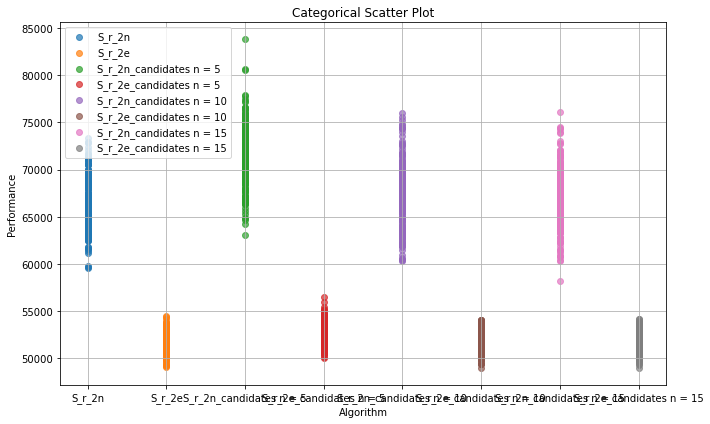

Wall time: 1h 57min 7s


In [6]:
%%time
best_solutions_c, results_list_c = run_all_experiments(200, experiments_provider(tspc, random_inits_c), tspc.get_solution_cost, experiments)

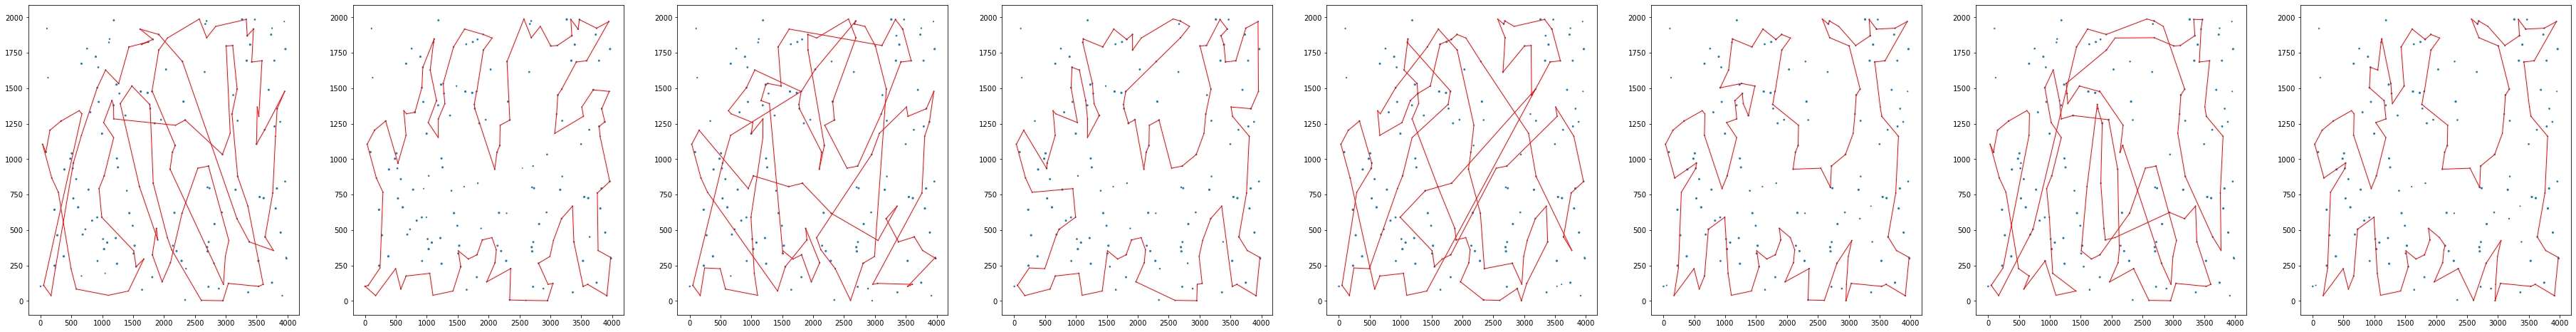

In [7]:
tspc.plot(best_solutions_c)

### Instance D


In [8]:
random_inits_d = [random_solution(tspd) for i in range(200)]

In [9]:
%%time
best_solutions_d, results_list_d = run_all_experiments(200, experiments_provider(tspd, random_inits_d), tspd.get_solution_cost, experiments)

**************************************************************************************************
S_r_2n:	

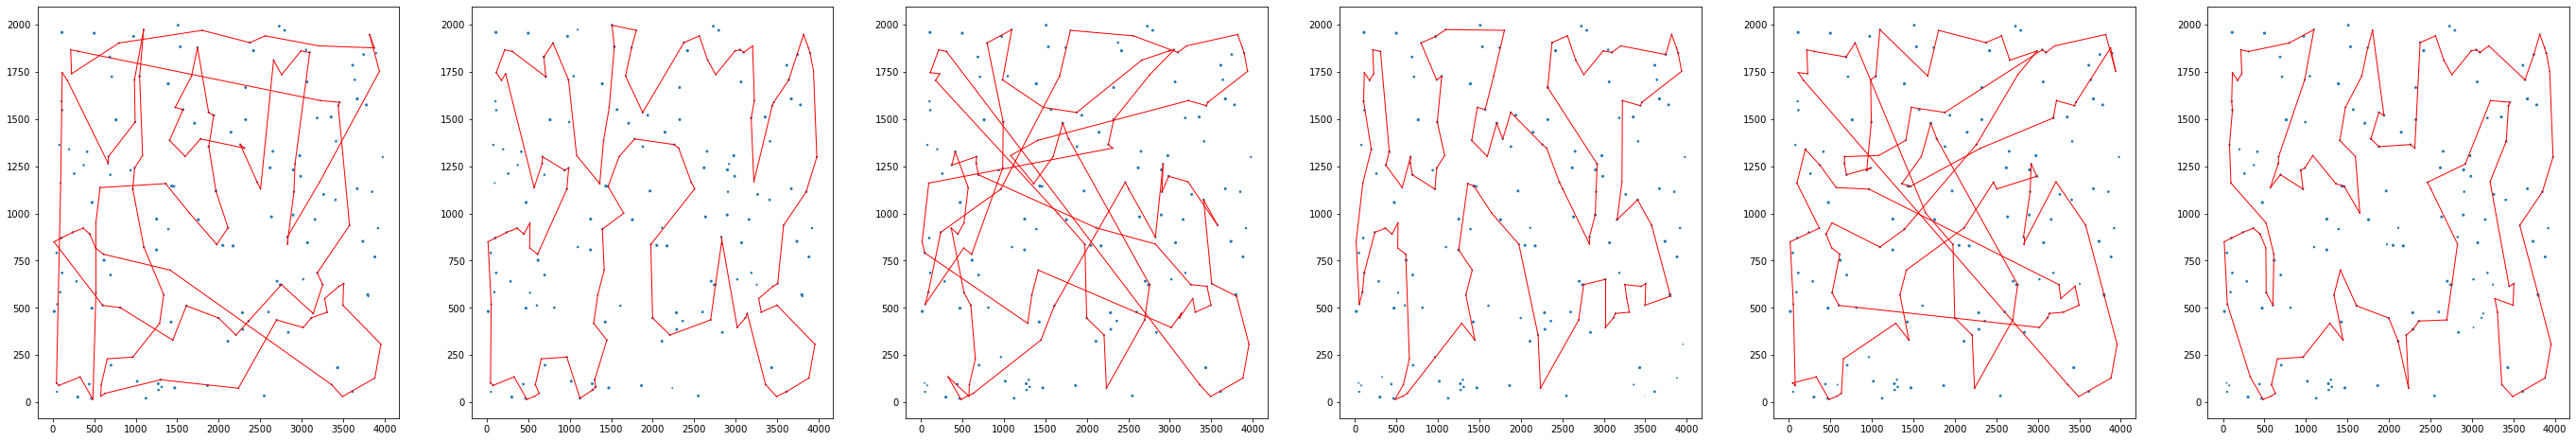

In [ ]:
tspd.plot(best_solutions_d)

In [ ]:
with open('results_c.json', 'w', encoding='utf-8') as f:
    json.dump(results_list_c, f, ensure_ascii=False, indent=4)
with open('best_solutions_c.json', 'w', encoding='utf-8') as f:
    json.dump(best_solutions_c, f, ensure_ascii=False, indent=4)

In [ ]:
with open('results_d.json', 'w', encoding='utf-8') as f:
    json.dump(results_list_d, f, ensure_ascii=False, indent=4)
with open('best_solutions_d.json', 'w', encoding='utf-8') as f:
    json.dump(best_solutions_d, f, ensure_ascii=False, indent=4)

## Conclusions

- The 2-edge neighborhood outperformed the 2-node neighborhood similarly as in the previous report.
- What is interesting the n-candidate parameter outperformed the original solution in the 2-node approach, which might be interpreted as not only a heurestic parameter, but also a regularization parameter, that has prevented stepping into local optima (in this case), overall it yelds results which are a bit worse than the original solution
- Experiments for the 2-egde neighborhood showed better performance indicating that the candidate-heuristic is well-cut for it - which makes sence because the heuristic is edge-based not vertex-based, and in the 2-node neighborhood method might lead (and probably did lead) to not picking the optimal vertex  since the two edges leading to it were not an obvious choice (they might be not that good separatly but they might form a good match together).   